<a href="https://colab.research.google.com/github/weibb123/BostonImageStyleTransfer/blob/main/%5BProject%5DArtistic_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

For this neural style transfer, we will be using Pytorch pretrained vgg19 model

In [ ]:
from PIL import Image  # use it to view image
import matplotlib.pyplot as plt
import numpy as np
import os

import torch
import torch.optim as optim
from torchvision import transforms, models

# Load in VGG features to do Style transfer
why VGG19 specifically? Since VGG19 is a relative simpler model compared with ResNet, Inception and etc. The feature maps works better than for style transfer as the paper suggested

In [ ]:
model = models.vgg19(pretrained=True).features # pytorch has pretrained vgg19 model so we just download it


In [ ]:
# I upload my images to google drive, so I will mount my drive to upload my images
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# we are going to freeze parameters of model to prevent them to be modified
for x in model.parameters():
  x.requires_grad_(False)


# move data to cuda to use GPU
model.to('cuda')

# Helper Function necessary for Style Transfer



In [ ]:
#Load_images/normalize function
def load_images(image_path, size=400, shape=None):
  """ go google drive and load images from google drive to colab
  and transform picture to feed in model
  size = 400 should be a reasonable size to display """

  img = Image.open(image_path).convert('RGB')

  # normalize image data
  in_transform = transforms.Compose([
                        transforms.Resize(size), # resize img to 400
                        transforms.ToTensor(), # convert to tensor data
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))]) # normalize data
  

  
  # add an additional dimension which is batch dimension
  img = in_transform(img)[:3,:,:].unsqueeze(0)

  return img

If we want to see what image is, we need to convert tensor data to numpy data

In [ ]:
# un-normalize data function
def image_to_arr(tensor):
  """a helper function that convert tensor data to 
  numpy data for visualizing image"""

  image = tensor.to("cpu").clone().detach() # create a new copy of the tensor
  image = image.numpy().squeeze() #get rid of useless one dimension arrays
  image = image.transpose(1,2,0)  # flips the image channels back to RGB.

  # Pytorch official uses st.dev std = [0.229, 0.224, 0.225], mean = [0.485, 0.456, 0.406]
  image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406)) # this line is saying image * std + mean
  image = image.clip(0, 1) # makes values smaller than 0 become 0, values greater than 1 become 1

  return image

In [ ]:
# features helper function
def img_to_features(image, model, layers=None):
    """ Run image through vgg19 model to get frozen parameters 
    """
    
    ## to reconstruct the style of input image, we will pull out these conv layers from model as the paper stated
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)  # pass img to layers in model
        if name in layers: # if found conv1-1, 2-1, 3-1, 4-1, 4-2, 5-1 in model._modules
            features[layers[name]] = x
            
    return features

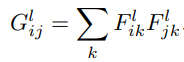\
Gram matrices

In [ ]:
# calculate gram_matrix helper function
def gram_matrix(tensor):
    """ Calculate the Gram Matrix of a given tensor """
    
    # get the batch_size, depth, height, and width of the Tensor
    _, d, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t()) # matrix multiplication
    
    return gram

In [ ]:
# helper function for visualizing
def visualize_image(image, style):
  # display the images
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10)) # create a subplots to display both content and style iamge
  
  # content and style ims side-by-side
  ax1.imshow(image_to_arr(image)) # use helper function convert image to array
  ax1.set_title("Original Image",fontsize = 20)
  ax2.imshow(image_to_arr(style))  # use helper function convert image to array
  ax2.set_title("Style Image", fontsize = 20)
  plt.show()

In [ ]:
# helper function for getting features from vgg19 model
def get_features(original, style, model):
  """get features of content and style """

  
  content_features = img_to_features(original, model) # run image through vgg to get features
  style_features = img_to_features(style, model) # run style image through vgg to get features

  # calculate the gram matrices for each layer of our style representation
  style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

  # create a third "target" image and prep it for change
  # it is a good idea to start of with the target as a copy of our *content* image
  # then iteratively change its style
  target = original.clone().requires_grad_(True).to('cuda')

  # weights for each style layer 
  # weighting earlier layers more will result in *larger* style artifacts
  # notice we are excluding `conv4_2` our content representation
  style_weights = {'conv1_1': 1.,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

  # choose weighting factors as the paper suggested 
  content_weight = 1  # alpha
  style_weight = 1e3  # beta

  ####### Iterate loss #######
  
  # for displaying the target image, intermittently
  show_every = 400

  # iteration hyperparameters
  optimizer = optim.Adam([target], lr=0.003)
  steps = 2000  # decide how many iterations to update your image (5000)

  for ii in range(1, steps+1):
    
    # get the features from your target image
    target_features = img_to_features(target, model)
    
    # the content loss
    content_loss = torch.mean((target_features['conv4_2'] - content_features['conv4_2'])**2)
    
    # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)
        _, d, h, w = target_feature.shape
        # get the "style" style representation
        style_gram = style_grams[layer]
        # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)
        
    # calculate the *total* loss
    total_loss = content_weight * content_loss + style_weight * style_loss
    
    # update your target image
    optimizer.zero_grad()
    total_loss.backward()
    optimizer.step()
    
    # display intermediate images and print the loss
    if  ii % show_every == 0:
        print('Total loss: ', total_loss.item())
        plt.imshow(image_to_arr(target))
        plt.show()

  # show final image
  fig, ax = plt.subplots(figsize=(20, 10))
  ax.imshow(image_to_arr(target))
  ax.set_title("Style Image", fontsize = 20)
  ax.set_xticks([])
  ax.set_yticks([])
  plt.show()



In [ ]:
# a dictionary that store all the picture
samples = {'picture_1': "/content/drive/MyDrive/picture1.jpg", 
          'style': "/content/drive/MyDrive/The-Starry-Night.jpg",
          'picture_2': '/content/drive/MyDrive/picture2.jpg',
          'picture_3': '/content/drive/MyDrive/picture3.jpg',
          'picture_4': '/content/drive/MyDrive/picture4.jpg',
           'starsky': '/content/drive/MyDrive/starnight.jpg',
           'picture_5': '/content/drive/MyDrive/IMG-8770.JPG',
           'picture_6': '/content/drive/MyDrive/IMG-8771.JPG',
           'weibb': '/content/drive/MyDrive/weiimg.png',
           'animesky': '/content/drive/MyDrive/animesky.jpg'}


## Trying other Boston Images

In [ ]:
def style_transfer(img_path, style_path):
  """ we will put all helper functions together in one function to do style transfer on other images"""
  image = load_images(samples[img_path], size = 400).to('cuda')
  style = load_images(samples[style_path], size = 400).to('cuda') # make sure style picture size match original picture

  # call helper function to see image
  visualize_image(image, style)

  # call helper function to get features for image and style
  get_features(image, style, model)

 


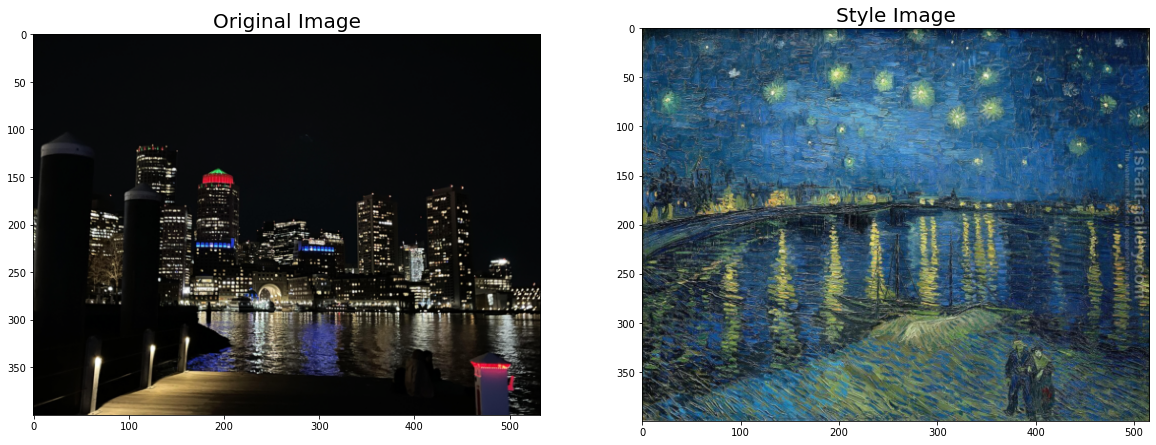

Total loss:  39611.8828125


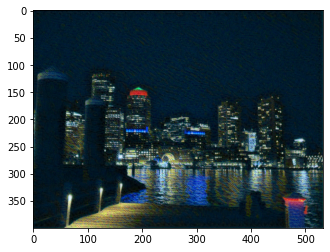

Total loss:  15663.78515625


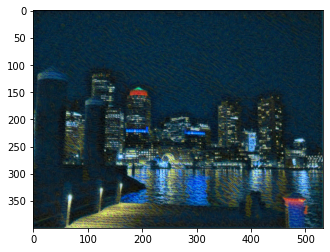

Total loss:  6414.69775390625


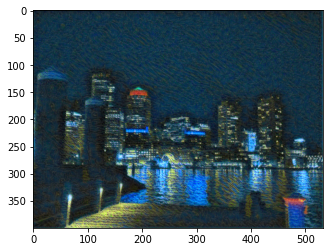

Total loss:  2657.37744140625


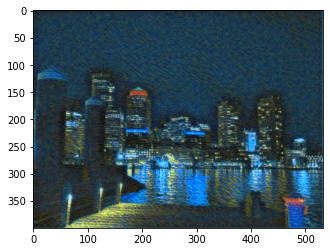

Total loss:  1256.696533203125


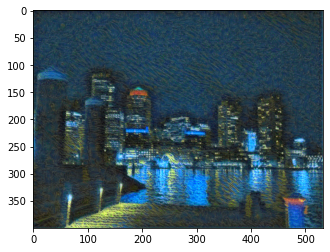

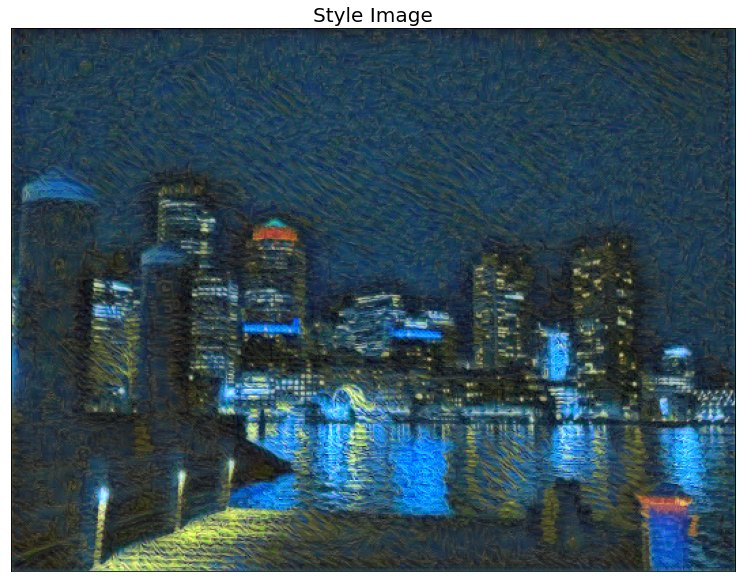

In [ ]:
style_transfer('picture_2', 'starsky')

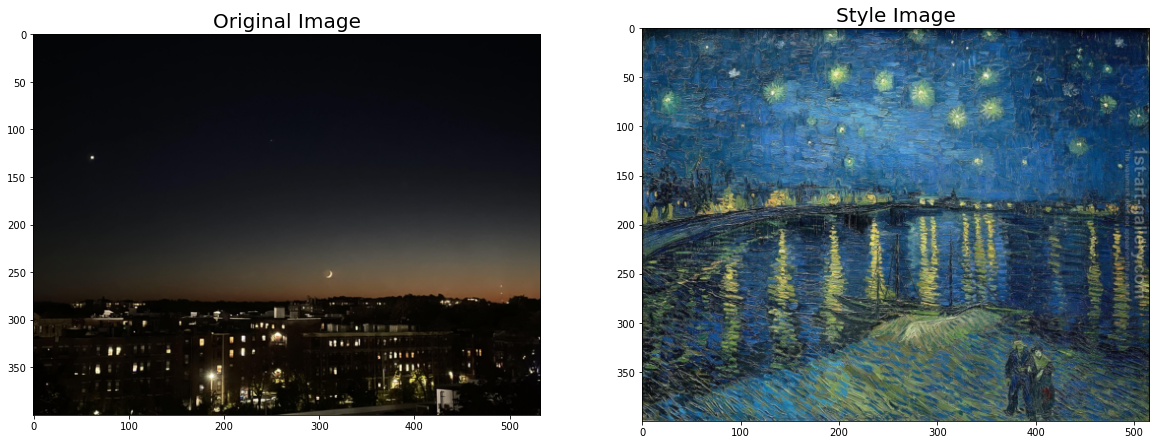

Total loss:  40913.234375


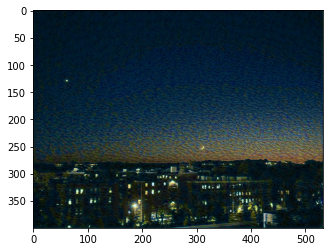

Total loss:  18284.625


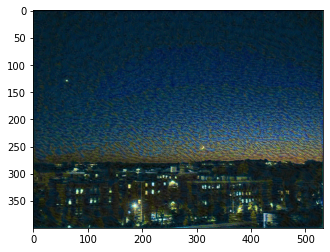

Total loss:  7779.435546875


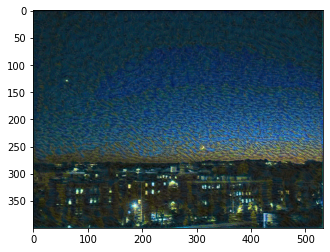

Total loss:  3089.937255859375


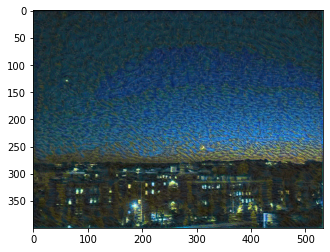

Total loss:  1300.684326171875


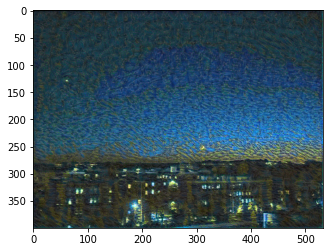

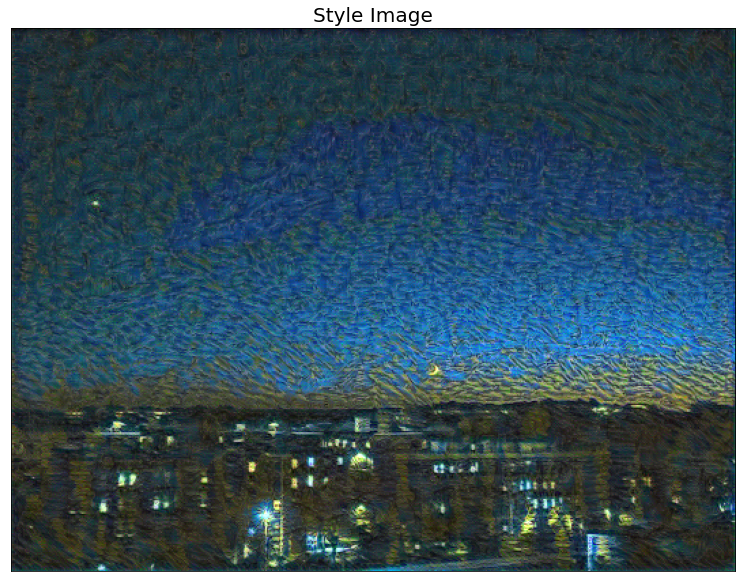

In [ ]:
style_transfer('picture_3', 'starsky')

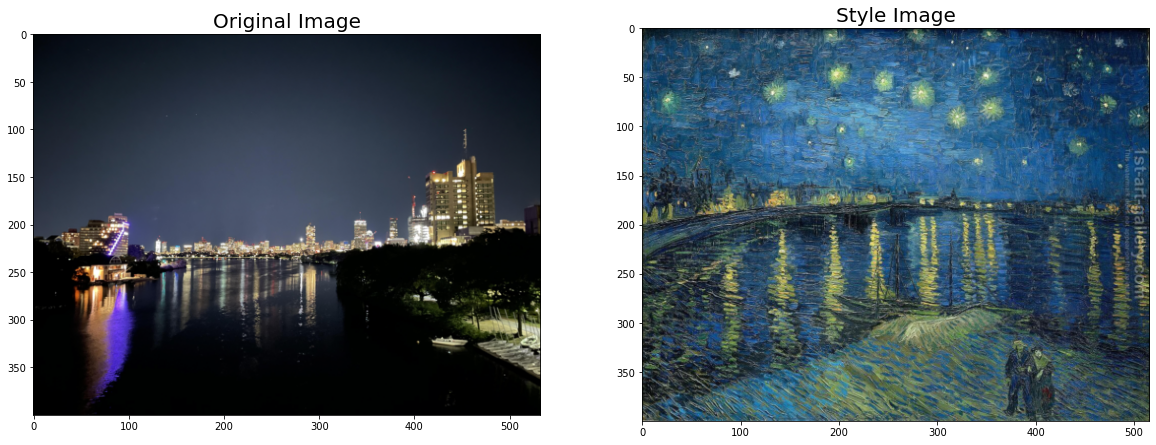

Total loss:  17138.55078125


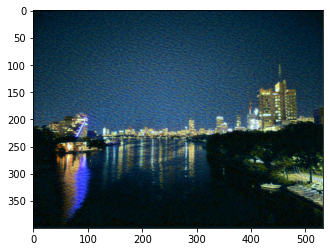

Total loss:  6874.9052734375


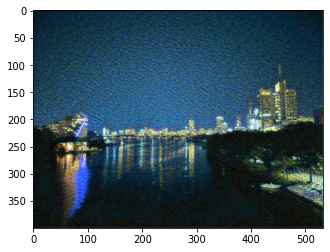

Total loss:  2988.82861328125


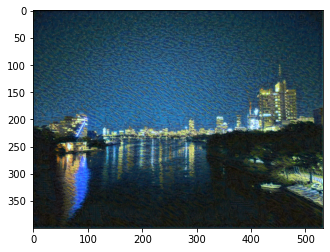

Total loss:  1433.137939453125


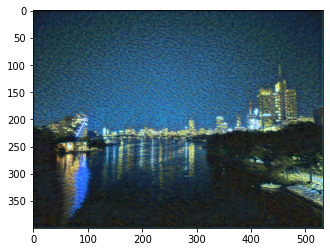

Total loss:  770.8629760742188


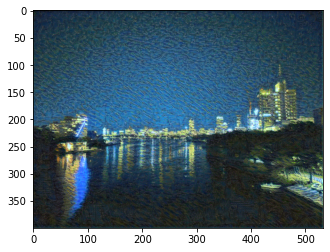

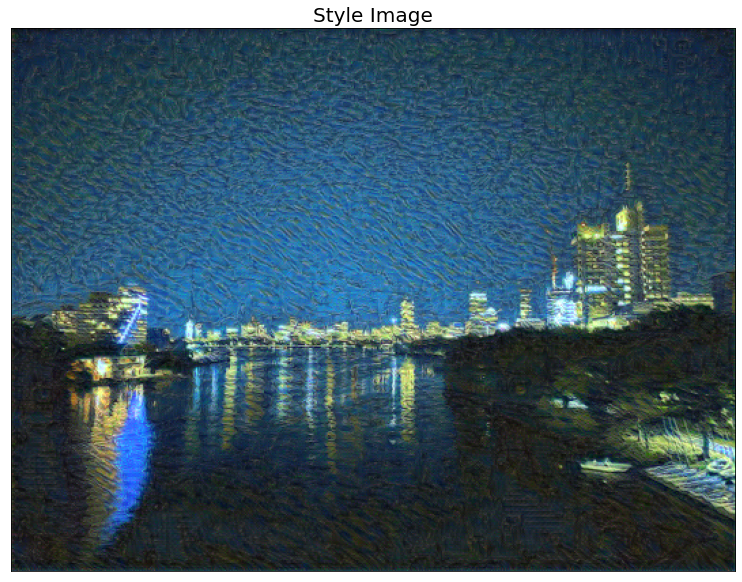

In [ ]:
style_transfer('picture_4', 'starsky')